In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import KFold
from sklearn import model_selection

In [2]:
cols=['parcelid', 'bathroomcnt', 'bedroomcnt','buildingqualitytypeid', 'calculatedbathnbr','calculatedfinishedsquarefeet','finishedsquarefeet12', 'fips', 'fullbathcnt', 'heatingorsystemtypeid', 
      'latitude', 'longitude', 'lotsizesquarefeet','propertycountylandusecode', 'propertylandusetypeid',
      'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity', 'regionidcounty', 'regionidzip', 'roomcnt',
      'unitcnt', 'yearbuilt','structuretaxvaluedollarcnt','taxvaluedollarcnt', 'assessmentyear', 
      'landtaxvaluedollarcnt', 'taxamount','censustractandblock']

In [3]:
train_df = pd.read_csv('E:/Chrome/train_2016_v2/train_2016_v2.csv')

In [4]:
chunk_df=pd.read_csv(r'E:/Chrome/properties_2016/properties_2016.csv',chunksize=10000,low_memory=False,usecols=cols)

In [5]:
chunk_list=[]
for chunk in chunk_df:
    chunk_list.append(chunk)


In [6]:
df_concats=pd.concat(chunk_list)

In [7]:
df_concats.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'heatingorsystemtypeid',
       'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock'],
      dtype='object')

In [8]:
train_df

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02
...,...,...,...
90270,10774160,-0.0356,2016-12-30
90271,12046695,0.0070,2016-12-30
90272,12995401,-0.2679,2016-12-30
90273,11402105,0.0602,2016-12-30


In [9]:
features=df_concats.columns
missing_df=[]
for feature in features:
    missing_feature=df_concats[feature].isnull().sum()
    missing_feature_per=100*(df_concats[feature].isnull().sum())/len(df_concats)
    data={'missing count':missing_feature,
          'missing percentage':missing_feature_per,
          'col':feature
         }
    missing_df.append(data)
missing_df=pd.DataFrame(missing_df)

In [10]:
missing_df=missing_df.set_index('col')
missing_df.sort_values(by='missing percentage', ascending=False)

,missing count,missing percentage
col,,
heatingorsystemtypeid,1178816,39.488453
buildingqualitytypeid,1046729,35.063749
unitcnt,1007727,33.757244
propertyzoningdesc,1006588,33.719090
lotsizesquarefeet,276099,9.248875
finishedsquarefeet12,276033,9.246664
fullbathcnt,128912,4.318346
calculatedbathnbr,128912,4.318346
censustractandblock,75126,2.516601


## Deleting columns with greater than 35% null values

In [11]:
df_concats.drop(missing_df[missing_df['missing percentage']>50].index,axis=1,inplace=True)

In [12]:
df_concats.shape

(2985217, 29)

## Merging the two DataFrames

In [13]:
data=pd.merge(train_df,df_concats,on='parcelid',how='left')

In [14]:
data

,parcelid,logerror,transactiondate,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,11016594,0.0276,2016-01-01,2.0,3.0,4.0,2.0,1684.0,1684.0,6037.0,...,96370.0,0.0,1.0,1959.0,122754.0,360170.0,2015.0,237416.0,6735.88,6.037107e+13
1,14366692,-0.1684,2016-01-01,3.5,4.0,NaN,3.5,2263.0,2263.0,6059.0,...,96962.0,0.0,NaN,2014.0,346458.0,585529.0,2015.0,239071.0,10153.02,NaN
2,12098116,-0.0040,2016-01-01,3.0,2.0,4.0,3.0,2217.0,2217.0,6037.0,...,96293.0,0.0,1.0,1940.0,61994.0,119906.0,2015.0,57912.0,11484.48,6.037464e+13
3,12643413,0.0218,2016-01-02,2.0,2.0,4.0,2.0,839.0,839.0,6037.0,...,96222.0,0.0,1.0,1987.0,171518.0,244880.0,2015.0,73362.0,3048.74,6.037296e+13
4,14432541,-0.0050,2016-01-02,2.5,4.0,NaN,2.5,2283.0,2283.0,6059.0,...,96961.0,8.0,NaN,1981.0,169574.0,434551.0,2015.0,264977.0,5488.96,6.059042e+13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90270,10774160,-0.0356,2016-12-30,1.0,1.0,4.0,1.0,653.0,653.0,6037.0,...,96364.0,0.0,1.0,1979.0,43800.0,191000.0,2015.0,147200.0,2495.24,6.037132e+13
90271,12046695,0.0070,2016-12-30,3.0,3.0,4.0,3.0,2856.0,2856.0,6037.0,...,96327.0,0.0,1.0,1965.0,117893.0,161111.0,2015.0,43218.0,1886.54,6.037301e+13
90272,12995401,-0.2679,2016-12-30,2.0,4.0,7.0,2.0,2617.0,NaN,6037.0,...,96478.0,0.0,2.0,1924.0,22008.0,38096.0,2015.0,16088.0,1925.70,6.037433e+13
90273,11402105,0.0602,2016-12-30,2.0,2.0,4.0,2.0,1034.0,1034.0,6037.0,...,96133.0,0.0,1.0,1981.0,132991.0,165869.0,2015.0,32878.0,2285.57,6.037601e+13


In [15]:
col_list=data.select_dtypes(include=['number']).columns

## Fetching the constant feature and deleting them

In [16]:
constant_features=[]
for col in col_list:
    if data[col].std()==0:
        print(col)
    


assessmentyear


In [17]:
data.drop('assessmentyear',axis=1, inplace=True)

In [18]:
data.describe()

,parcelid,logerror,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,...,regionidcounty,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock
count,9.027500e+04,90275.000000,90275.000000,90275.000000,57364.000000,89093.000000,89614.000000,85596.000000,90275.000000,89093.000000,...,90275.000000,90240.000000,90275.000000,58353.000000,89519.000000,8.989500e+04,9.027400e+04,9.027400e+04,90269.000000,8.967000e+04
mean,1.298466e+07,0.011457,2.279474,3.031869,5.565407,2.309216,1773.185987,1745.454531,6048.870551,2.241231,...,2525.420770,96586.131184,1.478516,1.110414,1968.532870,1.800934e+05,4.576726e+05,2.783353e+05,5983.975927,6.049151e+13
std,2.504510e+06,0.161079,1.004271,1.156436,1.900602,0.976172,928.162393,909.941166,20.663461,0.963142,...,805.694842,3661.339094,2.819627,0.797235,23.763475,2.091299e+05,5.548844e+05,4.004955e+05,6838.876956,2.046605e+11
min,1.071174e+07,-4.605000,0.000000,0.000000,1.000000,1.000000,2.000000,2.000000,6037.000000,1.000000,...,1286.000000,95982.000000,0.000000,1.000000,1885.000000,1.000000e+02,2.200000e+01,2.200000e+01,49.080000,6.037101e+13
25%,1.155950e+07,-0.025300,2.000000,2.000000,4.000000,2.000000,1184.000000,1172.000000,6037.000000,2.000000,...,1286.000000,96193.000000,0.000000,1.000000,1953.000000,8.124500e+04,1.990232e+05,8.222800e+04,2872.830000,6.037320e+13
50%,1.254734e+07,0.006000,2.000000,3.000000,7.000000,2.000000,1540.000000,1518.000000,6037.000000,2.000000,...,3101.000000,96393.000000,0.000000,1.000000,1970.000000,1.320000e+05,3.428720e+05,1.929700e+05,4542.750000,6.037615e+13
75%,1.422755e+07,0.039200,3.000000,4.000000,7.000000,3.000000,2095.000000,2056.000000,6059.000000,3.000000,...,3101.000000,96987.000000,0.000000,1.000000,1987.000000,2.105345e+05,5.405890e+05,3.454195e+05,6901.090000,6.059042e+13
max,1.629608e+08,4.737000,20.000000,16.000000,12.000000,20.000000,22741.000000,20013.000000,6111.000000,20.000000,...,3101.000000,399675.000000,18.000000,143.000000,2015.000000,9.948100e+06,2.775000e+07,2.450000e+07,321936.090000,6.111009e+13


In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90275 entries, 0 to 90274
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      90275 non-null  int64  
 1   logerror                      90275 non-null  float64
 2   transactiondate               90275 non-null  object 
 3   bathroomcnt                   90275 non-null  float64
 4   bedroomcnt                    90275 non-null  float64
 5   buildingqualitytypeid         57364 non-null  float64
 6   calculatedbathnbr             89093 non-null  float64
 7   calculatedfinishedsquarefeet  89614 non-null  float64
 8   finishedsquarefeet12          85596 non-null  float64
 9   fips                          90275 non-null  float64
 10  fullbathcnt                   89093 non-null  float64
 11  heatingorsystemtypeid         56080 non-null  float64
 12  latitude                      90275 non-null  float64
 13  l

In [21]:
data.transactiondate=pd.to_datetime(data.transactiondate)
data['transactionmonth']=data.transactiondate.dt.month

# DATA ANALYSIS

## 1. logerror and transactiondate

[]

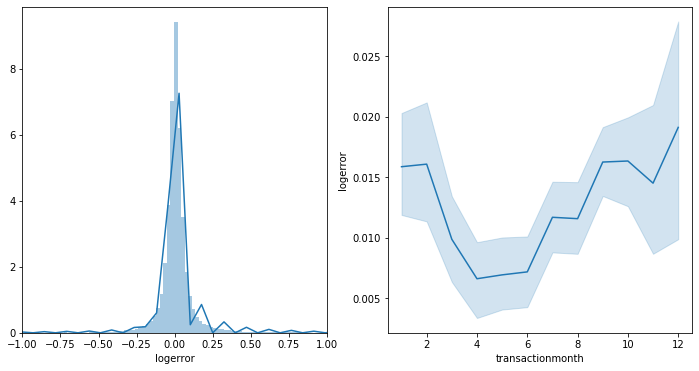

In [29]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
sns.distplot(data['logerror'],bins=400)
plt.xlim(-1,1)
plt.subplot(1,2,2)
sns.lineplot(x='transactionmonth',y='logerror',data=data)
plt.plot()

## 3.Bedroom Count

count    90275.000000
mean         3.031869
std          1.156436
min          0.000000
25%          2.000000
50%          3.000000
75%          4.000000
max         16.000000
Name: bedroomcnt, dtype: float64

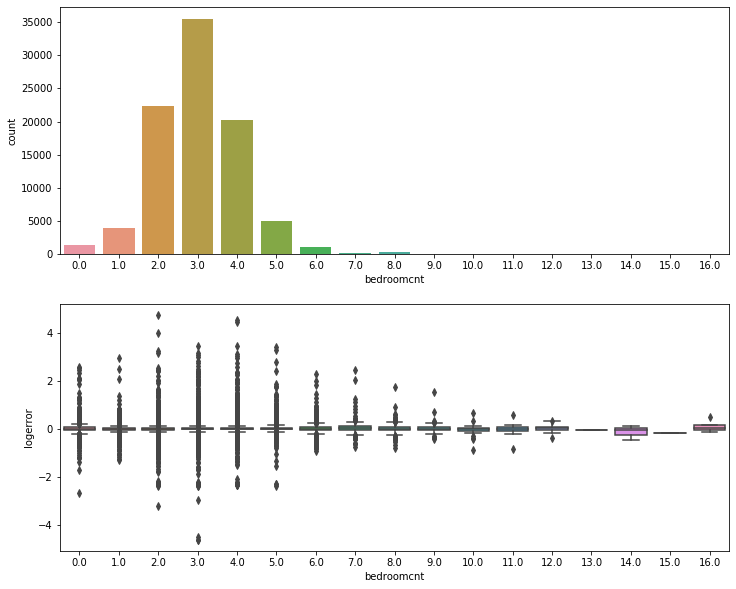

In [97]:
plt.figure(figsize=[12,10])
plt.subplot(2,1,1)
sns.countplot(data['bedroomcnt'])
plt.subplot(2,1,2)
sns.boxplot(x=data['bedroomcnt'] , y=data['logerror'])
plt.plot()

data['bedroomcnt'].describe()

### Bathroom Count

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

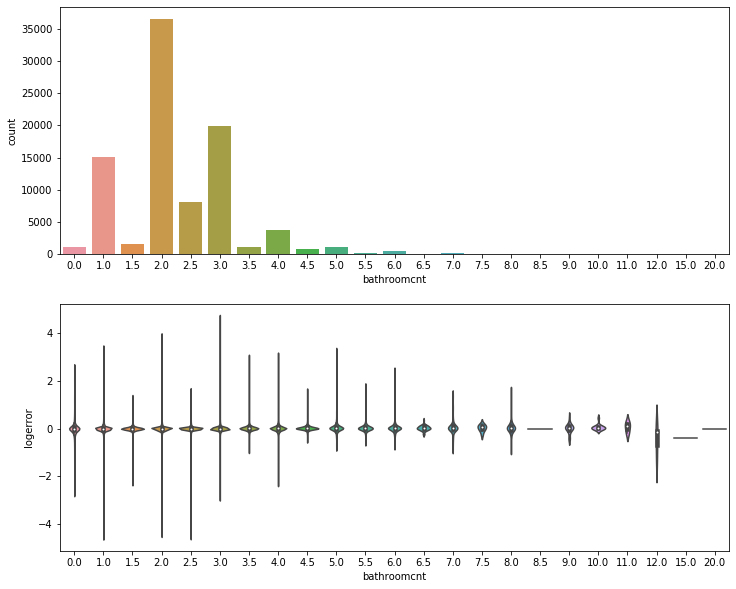

In [102]:
plt.figure(figsize=[12,10])
plt.subplot(2,1,1)
sns.countplot(data['bathroomcnt'])
plt.subplot(2,1,2)
sns.violinplot(x=data['bathroomcnt'] , y=data['logerror'])
plt.plot

## 4.calculatedbathnbr

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

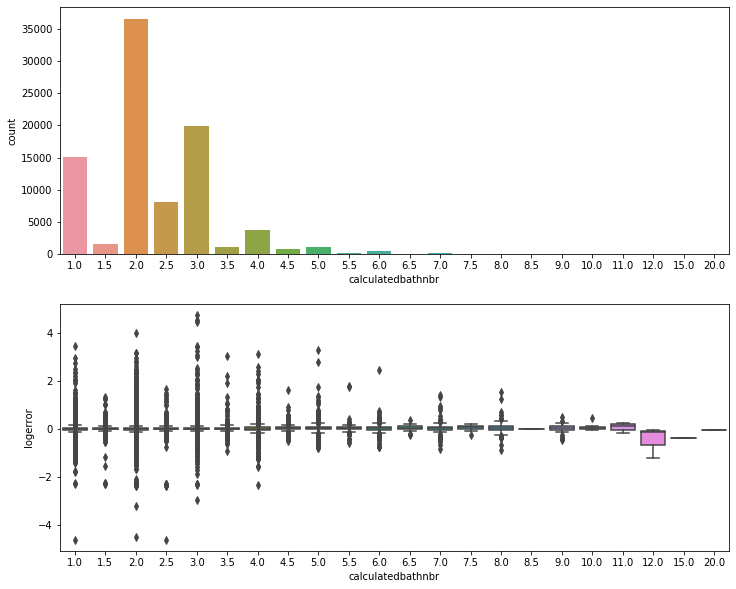

In [101]:
plt.figure(figsize=[12,10])
plt.subplot(2,1,1)
sns.countplot(data['calculatedbathnbr'])
plt.subplot(2,1,2)
sns.boxplot(x=data['calculatedbathnbr'] , y=data['logerror'])
plt.plot

In [103]:
data.calculatedbathnbr.corr(data.bathroomcnt)

0.9999999999999998

In [105]:
data[['calculatedbathnbr','bathroomcnt']].isnull().sum()

calculatedbathnbr    1182
bathroomcnt             0
dtype: int64

### let us drop calculatedbathnbr as it has null values and also the values are same in both

In [106]:
data.drop('calculatedbathnbr',axis=1,inplace=True)

## yearbuilt

[]

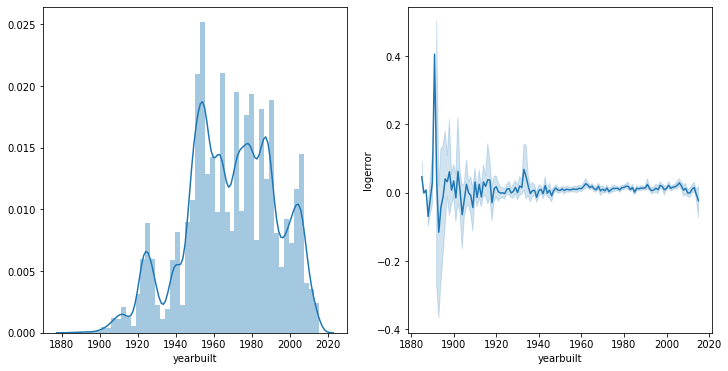

In [32]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
sns.distplot(data.yearbuilt)
plt.subplot(1,2,2)
sns.lineplot(x='yearbuilt',y='logerror',data=data)
plt.plot()


### calculatedfinishedsquarefeet

[]

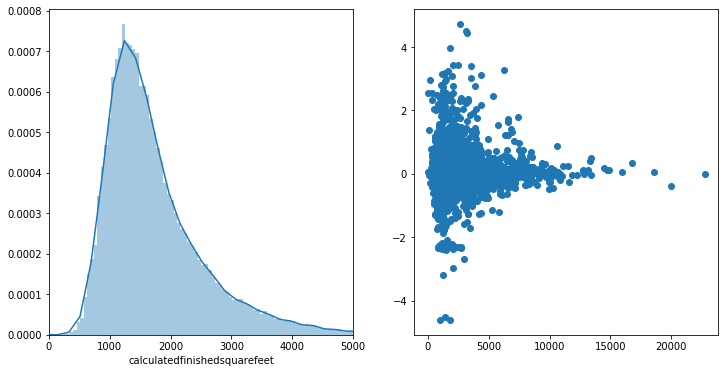

In [41]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
sns.distplot(data.calculatedfinishedsquarefeet,bins=400)
plt.xlim(0,5000)
plt.subplot(1,2,2)
plt.scatter(x='calculatedfinishedsquarefeet',y='logerror',data=data)
plt.plot()


### finishedsquarefeet12

[]

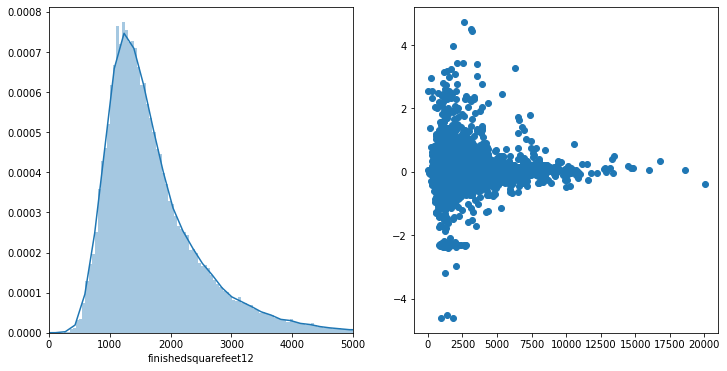

In [44]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
sns.distplot(data.finishedsquarefeet12,bins=400)
plt.xlim(0,5000)
plt.subplot(1,2,2)
plt.scatter(x='finishedsquarefeet12',y='logerror',data=data)
plt.plot()


### fips

[]

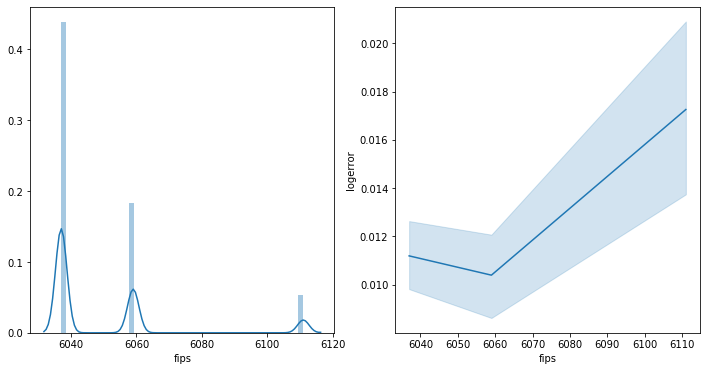

In [45]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
sns.distplot(data.fips)
plt.subplot(1,2,2)
sns.lineplot(x='fips',y='logerror',data=data)
plt.plot()


### fullbathcnt                   

[]

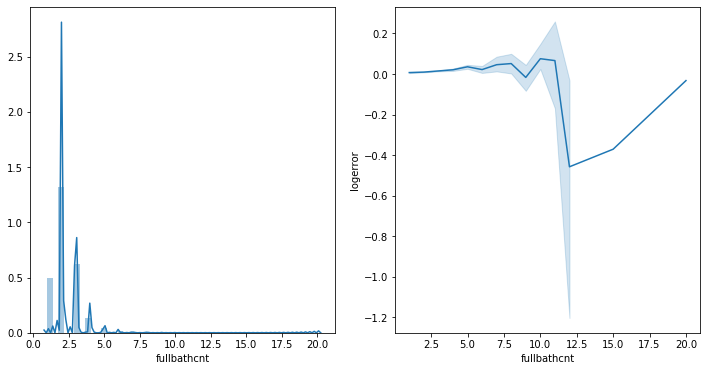

In [46]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
sns.distplot(data.fullbathcnt)
plt.subplot(1,2,2)
sns.lineplot(x='fullbathcnt',y='logerror',data=data)
plt.plot()


### latitude                      

[]

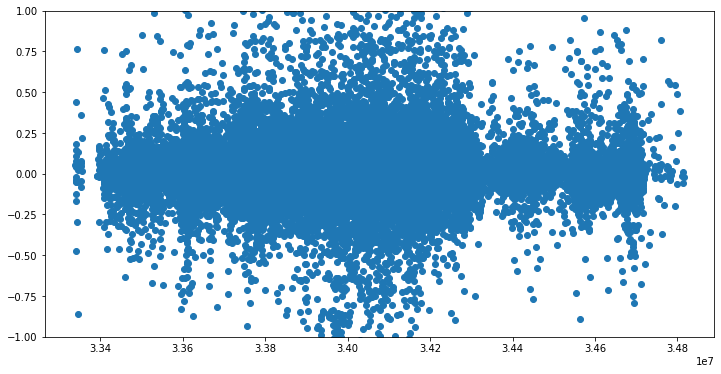

In [36]:
plt.figure(figsize=[12,6])
plt.scatter(x='latitude',y='logerror',data=data)
plt.ylim(-1,1)
plt.plot()


### longitude

[]

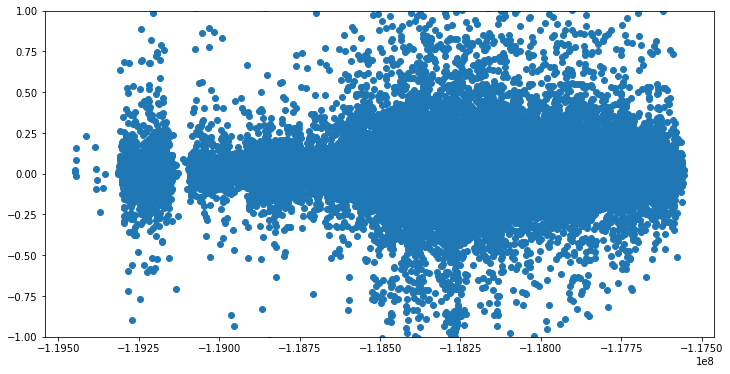

In [37]:
plt.figure(figsize=[12,6])
plt.scatter(x='longitude',y='logerror',data=data)
plt.ylim(-1,1)
plt.plot()


### lotsizesquarefeet

[]

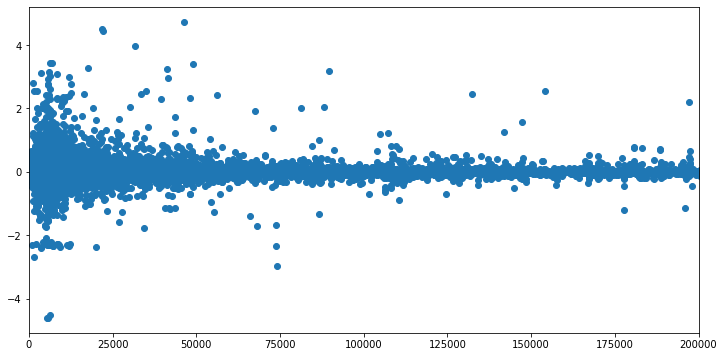

In [54]:
plt.figure(figsize=[12,6])

plt.scatter(x='lotsizesquarefeet',y='logerror',data=data)
plt.xlim(0,200000)
plt.plot()


### buildingqualitytypeid

[]

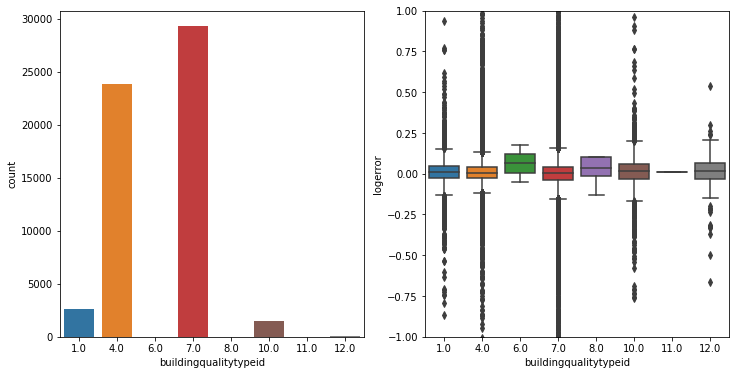

In [116]:
plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
sns.countplot(data['buildingqualitytypeid'])
plt.subplot(1,2,2)
sns.boxplot(x='buildingqualitytypeid',y='logerror',data=data)
plt.ylim(-1,1)
plt.plot()


In [229]:
data['buildingqualitytypeid'].value_counts()

7.0     29310
4.0     23839
1.0      2627
10.0     1461
12.0      119
8.0         5
6.0         2
11.0        1
Name: buildingqualitytypeid, dtype: int64

### taxamount

[]

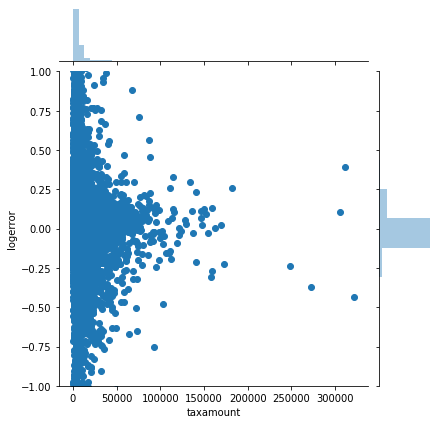

In [107]:
sns.jointplot(x=data.taxamount,y=data.logerror)
plt.ylim(-1,1)
plt.plot()

### heatingorsystemtypeid

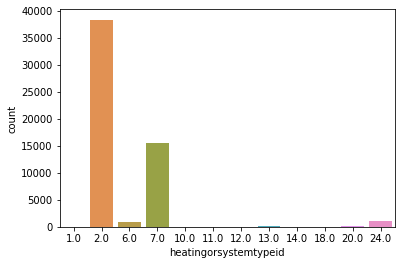

In [231]:
sns.countplot(data['heatingorsystemtypeid'])

### propertyzoningdesc ,	propertycountylandusecode

In [130]:
data[['propertyzoningdesc','propertycountylandusecode']]

,propertyzoningdesc,propertycountylandusecode
0,LARS,0100
1,NaN,1
2,PSR6,0100
3,LAR3,010C
4,NaN,122
...,...,...
90270,LARD1.5,010C
90271,GLR1RY,0100
90272,EMR3YY,0200
90273,INR4*,010C


In [55]:
data.drop(['propertyzoningdesc','propertycountylandusecode'],axis=1,inplace=True)

### calculatedfinishedsquarefeet and finishedsquarefeet12 are same so we can remove 1

In [90]:
data[['calculatedfinishedsquarefeet','finishedsquarefeet12']].isnull().sum()

calculatedfinishedsquarefeet     661
finishedsquarefeet12            4679
dtype: int64

In [91]:
data[['calculatedfinishedsquarefeet','finishedsquarefeet12']].isnull().sum(axis=1).value_counts()

0    85596
1     4018
2      661
dtype: int64

In [85]:
data.loc[data[data[['calculatedfinishedsquarefeet','finishedsquarefeet12']].isna()].index,['calculatedfinishedsquarefeet','finishedsquarefeet12']]

,calculatedfinishedsquarefeet,finishedsquarefeet12
0,1684.0,1684.0
1,2263.0,2263.0
2,2217.0,2217.0
3,839.0,839.0
4,2283.0,2283.0
...,...,...
90270,653.0,653.0
90271,2856.0,2856.0
90272,2617.0,NaN
90273,1034.0,1034.0


In [92]:
data.drop('finishedsquarefeet12',inplace=True, axis=1)

#### The above two properties have quite a lot of different variety so can be removed as these many propperties will be difficault to analyse

In [26]:
data.transactiondate

0        2016-01-01
1        2016-01-01
2        2016-01-01
3        2016-01-02
4        2016-01-02
            ...    
90270    2016-12-30
90271    2016-12-30
90272    2016-12-30
90273    2016-12-30
90274    2016-12-30
Name: transactiondate, Length: 90275, dtype: object

In [56]:
data.drop('transactiondate', axis=1,inplace=True)

In [108]:
## Let us copy the data in different Dataframe and then proceed with the cleaning
df=data.copy()

## DATA CORRELATION

In [109]:
def correlation(dataset,threshold):
    corr_set=set()
    corr_data=dataset.corr()
    for i in range(len(dataset.corr().columns)):
        for j in range(i):
            if abs(corr_data.iloc[i,j])>threshold:
                corr_set.add(corr_data.columns[i])
    return corr_set

corr_features=correlation(df,0.8)

In [110]:
corr_features

{'censustractandblock',
 'fullbathcnt',
 'landtaxvaluedollarcnt',
 'rawcensustractandblock',
 'taxamount',
 'taxvaluedollarcnt'}

In [111]:
## Another way to check coorelated features
corr_data=df.corr()
corr_data=corr_data.abs().unstack()
corr_data=corr_data[(corr_data>=0.9) & (corr_data<1)]
corr_data = pd.DataFrame(corr_data).reset_index()
corr_data.columns=['feature1','feature2','corr']

In [112]:
corr_data

,feature1,feature2,corr
0,bathroomcnt,fullbathcnt,0.984130
1,fips,rawcensustractandblock,0.999937
2,fips,censustractandblock,0.999759
3,fullbathcnt,bathroomcnt,0.984130
4,rawcensustractandblock,fips,0.999937
5,rawcensustractandblock,censustractandblock,0.999822
6,taxvaluedollarcnt,landtaxvaluedollarcnt,0.955336
7,taxvaluedollarcnt,taxamount,0.949376
8,landtaxvaluedollarcnt,taxvaluedollarcnt,0.955336
9,landtaxvaluedollarcnt,taxamount,0.902713


In [113]:
X_sel=df.drop('logerror',axis=1)
y=df['logerror']
X_train,X_test,y_train,y_test=train_test_split(X_sel,y,random_state=40,test_size=0.3)
X_train.shape ,X_test.shape , y_train.shape ,y_test.shape

((63192, 25), (27083, 25), (63192,), (27083,))

In [115]:
feature_unique=corr_data.feature1.unique()
feature_unique
col_test=[]
for i in feature_unique:
    li=[]
    col_test=corr_data[corr_data.feature1==i]
    li=col_test.feature1.unique()
    li=np.append(li,col_test.feature2.unique())
    rf = RandomForestRegressor()
    rf.fit(X_train[li].fillna(0), y_train)
    importance = pd.concat([pd.Series(li), pd.Series(rf.feature_importances_)], axis=1)

    importance.columns = ['feature', 'importance']
    importance.sort_values(by='importance', ascending=False)
    print(importance)



       feature  importance
0  bathroomcnt    0.598018
1  fullbathcnt    0.401982
                  feature  importance
0                    fips    0.001437
1  rawcensustractandblock    0.610145
2     censustractandblock    0.388418
       feature  importance
0  fullbathcnt    0.377505
1  bathroomcnt    0.622495
                  feature  importance
0  rawcensustractandblock    0.614435
1                    fips    0.000987
2     censustractandblock    0.384579
                 feature  importance
0      taxvaluedollarcnt    0.319157
1  landtaxvaluedollarcnt    0.328365
2              taxamount    0.352478
                 feature  importance
0  landtaxvaluedollarcnt    0.333036
1      taxvaluedollarcnt    0.319283
2              taxamount    0.347681
                 feature  importance
0              taxamount    0.347002
1      taxvaluedollarcnt    0.316099
2  landtaxvaluedollarcnt    0.336899
                  feature  importance
0     censustractandblock    0.394091
1             

### We will keep important feature of each group and delete the other

In [117]:
df.drop(['fullbathcnt','fips','censustractandblock','taxvaluedollarcnt','landtaxvaluedollarcnt'],axis=1,inplace=True)

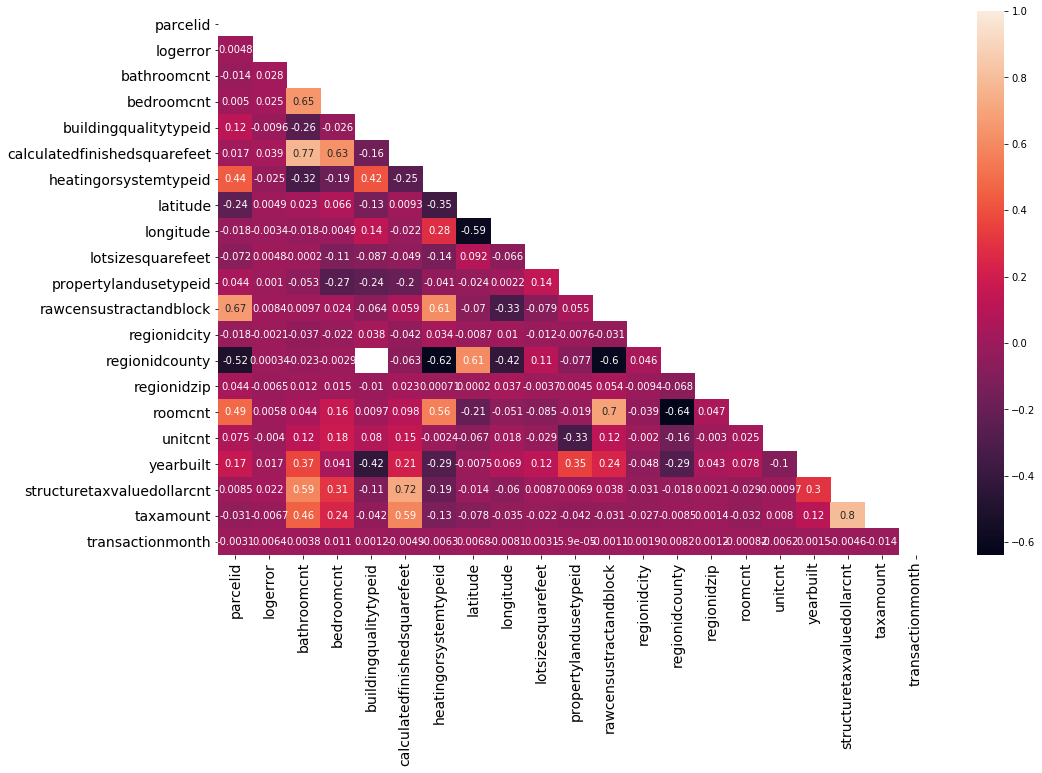

In [118]:
mask=np.zeros_like(df.corr())
indent=np.triu_indices_from(mask)
mask[indent]=True
plt.figure(figsize=[16,10])
sns.heatmap(df.corr(),annot=True,mask=mask, annot_kws={"size":10})
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [ ]:
####   calculatedfinishedsquarefeet has high correlation with log error as comapre to other variables

[]

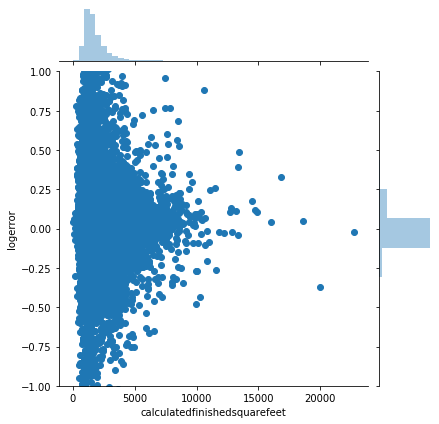

In [68]:
sns.jointplot(x=df.calculatedfinishedsquarefeet,y=df.logerror)
plt.ylim(-1,1)
plt.plot()

### We can drop regionidcounty as it very much less correlated to logerror

In [119]:
df.drop('regionidcounty',axis=1,inplace=True)

### Checking VIF

In [120]:
num_data=data.dropna(how='any',axis=0)._get_numeric_data()
num_data.isnull().sum()
vif = pd.DataFrame()
vif["VIF Factor"] = [round(variance_inflation_factor(num_data.values, i),3) for i in range(num_data.shape[1])]
vif["features"] = num_data.columns
vif

D:\Installation\lib\site-packages\statsmodels\regression\linear_model.py:1685: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
D:\Installation\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF Factor,features
0,5.889000e+00,parcelid
1,1.006000e+00,logerror
2,9.672015e+09,bathroomcnt
3,2.289000e+00,bedroomcnt
4,1.373000e+00,buildingqualitytypeid
5,4.776000e+00,calculatedfinishedsquarefeet
6,0.000000e+00,fips
7,2.029750e+10,fullbathcnt
8,1.764000e+00,heatingorsystemtypeid
9,2.940000e+00,latitude


In [148]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79699 entries, 0 to 90274
Data columns (total 19 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      79699 non-null  int64  
 1   logerror                      79699 non-null  float64
 2   bathroomcnt                   79699 non-null  float64
 3   bedroomcnt                    79699 non-null  float64
 4   buildingqualitytypeid         55956 non-null  float64
 5   calculatedfinishedsquarefeet  79699 non-null  float64
 6   heatingorsystemtypeid         53206 non-null  float64
 7   latitude                      79699 non-null  float64
 8   longitude                     79699 non-null  float64
 9   lotsizesquarefeet             79699 non-null  float64
 10  propertylandusetypeid         79699 non-null  float64
 11  rawcensustractandblock        79699 non-null  float64
 12  regionidcity                  78108 non-null  float64
 13  r

In [122]:
df.unitcnt.value_counts()

1.0      54503
2.0       2354
4.0        871
3.0        619
6.0          1
5.0          1
9.0          1
11.0         1
143.0        1
70.0         1
Name: unitcnt, dtype: int64

###  We can delete unit count as max are 54000 are 1 and around 50% are null so it wont make much difference 


In [123]:
df.drop('unitcnt',axis=1 , inplace=True)

[]

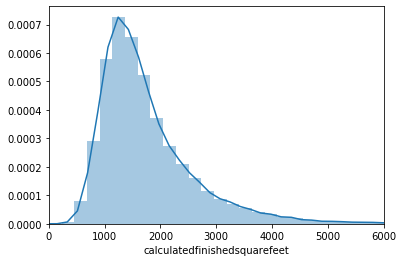

In [128]:
sns.distplot(df.calculatedfinishedsquarefeet,bins=100)
plt.xlim(0,6000)
plt.plot()

In [129]:
df.calculatedfinishedsquarefeet.describe()

count    89614.000000
mean      1773.185987
std        928.162393
min          2.000000
25%       1184.000000
50%       1540.000000
75%       2095.000000
max      22741.000000
Name: calculatedfinishedsquarefeet, dtype: float64

In [130]:
df.calculatedfinishedsquarefeet.fillna(df.calculatedfinishedsquarefeet.median(),inplace=True)

[]

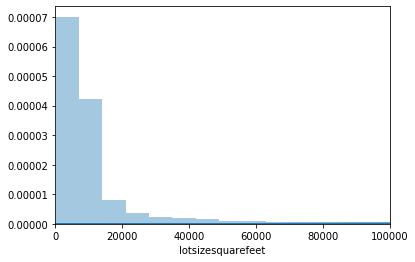

In [136]:
sns.distplot(df.lotsizesquarefeet,bins=1000)
plt.xlim(0,100000)
plt.plot()

In [168]:
df.lotsizesquarefeet.describe()

count    8.012500e+04
mean     2.911016e+04
std      1.217213e+05
min      1.670000e+02
25%      5.703000e+03
50%      7.200000e+03
75%      1.168600e+04
max      6.971010e+06
Name: lotsizesquarefeet, dtype: float64

#### As the count varies too muh let us drop the null rows

In [137]:
df.drop(df[df.lotsizesquarefeet.isna()].index,inplace=True)

[]

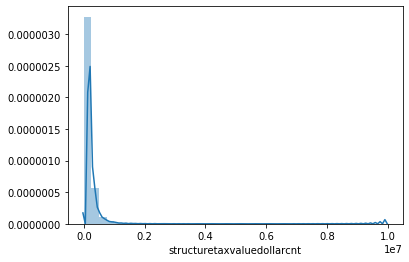

In [140]:
sns.distplot(df.structuretaxvaluedollarcnt,bins=40)
plt.plot()

In [176]:
df.structuretaxvaluedollarcnt.describe()

count    8.989500e+04
mean     1.800934e+05
std      2.091299e+05
min      1.000000e+02
25%      8.124500e+04
50%      1.320000e+05
75%      2.105345e+05
max      9.948100e+06
Name: structuretaxvaluedollarcnt, dtype: float64

In [141]:
df.structuretaxvaluedollarcnt.fillna(df.structuretaxvaluedollarcnt.median(),inplace=True)

In [142]:
df[df.yearbuilt.isna()].index

Int64Index([  126,   293,   299,   303,   387,   734,   875,   950,  1220,
             1222,
            ...
            87089, 87290, 88001, 88175, 88937, 89105, 89637, 89651, 89752,
            89840],
           dtype='int64', length=426)

In [143]:
df.drop(df[df.yearbuilt.isna()].index,inplace=True)

[]

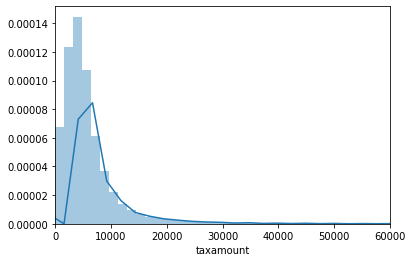

In [146]:
sns.distplot(df.taxamount,bins=200)
plt.xlim(0,60000)
plt.plot()

In [149]:
df.taxamount.fillna(df.taxamount.median(),inplace=True)

### regionidcity has only 5 null values so filling with max value

In [150]:
df.regionidcity.fillna(12447.0,inplace=True)

In [151]:
df.drop(df[df.regionidzip.isna()].index,inplace=True)

In [152]:
df.isnull().sum()

parcelid                            0
logerror                            0
bathroomcnt                         0
bedroomcnt                          0
buildingqualitytypeid           23738
calculatedfinishedsquarefeet        0
heatingorsystemtypeid           26488
latitude                            0
longitude                           0
lotsizesquarefeet                   0
propertylandusetypeid               0
rawcensustractandblock              0
regionidcity                        0
regionidzip                         0
roomcnt                             0
yearbuilt                           0
structuretaxvaluedollarcnt          0
taxamount                           0
transactionmonth                    0
dtype: int64

In [155]:
df.buildingqualitytypeid.value_counts()

7.0     29111
4.0     22955
1.0      2399
10.0     1367
12.0      117
8.0         5
6.0         1
11.0        1
Name: buildingqualitytypeid, dtype: int64

In [156]:
df.heatingorsystemtypeid.value_counts()

2.0     36994
7.0     15446
6.0       663
20.0       57
13.0       29
1.0         7
18.0        3
24.0        2
14.0        2
10.0        2
11.0        1
Name: heatingorsystemtypeid, dtype: int64

### Null Values are very high better to drop these columns

In [157]:
df.drop(['heatingorsystemtypeid','buildingqualitytypeid'],axis=1, inplace=True)

In [158]:
df.drop('parcelid',axis=1,inplace=True)

In [232]:
df.columns

Index(['logerror', 'bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
       'calculatedfinishedsquarefeet', 'finishedsquarefeet12', 'latitude',
       'longitude', 'lotsizesquarefeet', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity', 'regionidzip', 'roomcnt',
       'yearbuilt', 'structuretaxvaluedollarcnt', 'taxamount'],
      dtype='object')

In [159]:
X=df.drop('logerror',axis=1)
y=df['logerror']

In [160]:

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.33, random_state=42)
X_train.shape , X_test.shape , y_train.shape , y_test.shape

((53394, 15), (26300, 15), (53394,), (26300,))

In [162]:
regr=RandomForestRegressor()
regr.fit(X_train,y_train)
print(f'regression score for train data set : {regr.score(X_train,y_train)}')


regression score for train data set : 0.8609412869307403


In [163]:
feature_sel=pd.DataFrame({'Variables':X_train.columns,'Features':regr.feature_importances_})
feature_sel.sort_values(by='Features',ascending=False,inplace=True)
feature_sel

,Variables,Features
13,taxamount,0.120220
12,structuretaxvaluedollarcnt,0.115482
5,lotsizesquarefeet,0.111038
3,latitude,0.108488
2,calculatedfinishedsquarefeet,0.107357
4,longitude,0.104298
11,yearbuilt,0.072354
9,regionidzip,0.056217
14,transactionmonth,0.053761
7,rawcensustractandblock,0.052681


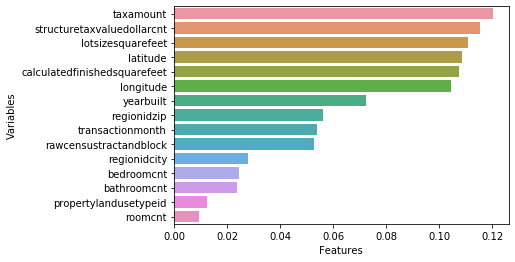

In [164]:
sns.barplot(x='Features',y='Variables',data=feature_sel)